# Build a Traffic Sign Recognition Classifier

In [372]:
import pickle
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time
import glob

%matplotlib inline

## Step 0: Load The Data

In [2]:
CWD = os.getcwd()

training_file = CWD + '/traffic-signs-data/train.p'
validation_file = CWD + '/traffic-signs-data/valid.p'
testing_file = CWD + '/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# write pickle files for python 2.7
pickle.dump(train, open(CWD + "/traffic-signs-data/train.pkl","wb"), protocol=2)
pickle.dump(valid, open(CWD + "/traffic-signs-data/valid.pkl","wb"), protocol=2)
pickle.dump(test, open(CWD + "/traffic-signs-data/test.pkl","wb"), protocol=2)

In [389]:
CWD = os.getcwd()

training_file = CWD + '/traffic-signs-data/train.p'
validation_file = CWD + '/traffic-signs-data/valid.p'
testing_file = CWD + '/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [390]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

image_shape = X_train[0].shape

# Count unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_valid, y_test), axis = 0)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the data

37


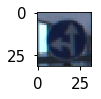

In [391]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[5000].squeeze(), cmap="gray")
print(y_train[5000])

In [392]:
def create_counter_df(data, dataset):
    counter_df = pd.DataFrame.from_dict(collections.Counter(data), orient='index').reset_index()
    counter_df.columns = ['label', 'cnt']
    counter_df['dataset'] = dataset
    counter_df['prop'] = counter_df['cnt']/counter_df['cnt'].sum()
    return counter_df

In [393]:
y_train_df = create_counter_df(y_train, 'train')
y_valid_df = create_counter_df(y_valid, 'valid')
y_test_df = create_counter_df(y_test, 'test')

In [6]:
y_train_dict = collections.Counter(y_train)
y_valid_dict = collections.Counter(y_valid)
y_test_dict = collections.Counter(y_test)

In [394]:
plot_df = pd.concat([y_train_df, y_valid_df, y_test_df])

Text(0.5,0,'Label')

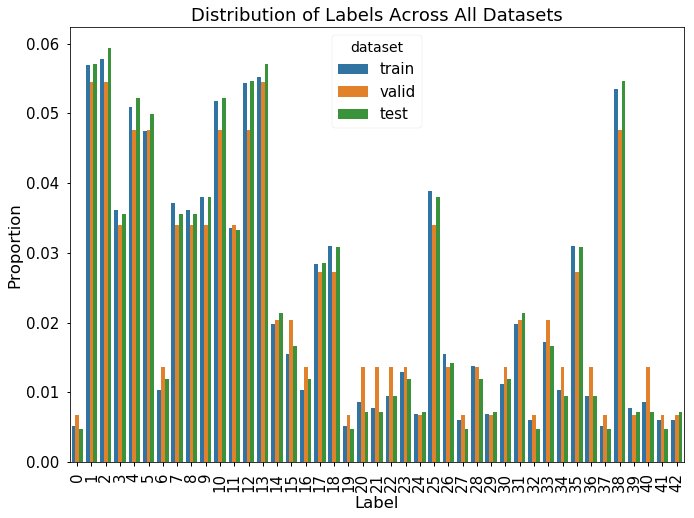

In [398]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
y_train_dist = sns.barplot(x = plot_df['label'], y = plot_df['prop'], hue = plot_df['dataset'])
plt.xticks(rotation=90)
plt.title('Distribution of Labels Across All Datasets')
plt.ylabel('Proportion')
plt.xlabel('Label')

We don't have to worry about unbalanced data because the distributions across the different datasets are similar. The maximum difference of label proportions is only 0.007 between the 'validation' and 'test' dataset for label '12'.

Text(0.5,0,'Label')

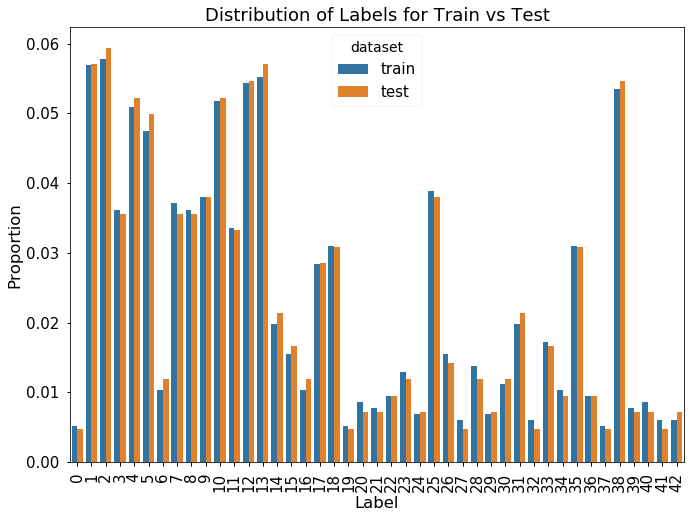

In [399]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
y_train_dist = sns.barplot(x = plot_df[plot_df.dataset != 'valid']['label'], \
                           y = plot_df[plot_df.dataset != 'valid']['prop'], \
                           hue = plot_df[plot_df.dataset != 'valid']['dataset'], \
                           data = plot_df.loc[plot_df.dataset != 'valid'])
plt.xticks(rotation=90)
plt.title('Distribution of Labels for Train vs Test')
plt.ylabel('Proportion')
plt.xlabel('Label')

The label distribution between train and test is even more similar with a maximum difference of 0.002 for label '28'.

----

## Step 2: Design and Test a Model Architecture

Here are some aspects I considered when designing the pipeline:

- Preprocessing techniques (normalization, rgb to grayscale, etc.)
- Generating fake data
- Neural network architecture (LeNet-5, LeCun's 2 stage ConvNet)

### 2.1: Pre-process the data set (normalization, grayscale, etc.)

In [10]:
def normalize(img):
    """Normalize (subtract mean and divide by std dev) image
    
    Parameters
    ----------
    img : numpy array
        Input image
    
    Returns
    -------
    new_img : numpy array
        Normalized image
    """
    new_img = np.float32(img)
    new_img -= np.mean(new_img, axis=0)
    new_img /= (np.std(new_img, axis=0) + np.finfo('float32').eps)
    return new_img

def preprocess_img(img):
    """Helper function to transform a single image to gray scale and normalize to force the range of pixel 
        intensity to [0,1]
    
    Parameters
    ----------
    img : numpy array
        Original image represeted as an array
    
    Returns
    -------
    gray_img : numpy array
        Image with one color channel and with a range of pixel intensity of [0,1] 
    """
    # Convert to YUV 
    new_img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0], axis = 2)
    # create and apply CLAHE object
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(2,2))
    new_img = clahe.apply(new_img)
    # standardize features
    new_img = normalize(new_img)
    return new_img

In [11]:
def preprocess(imgs):
    """Preprocess all images by transforming to gray scale and normalizing
    
    Parameters
    ----------
    imgs : numpy ndarray
        All original images with shape (num_images, 32, 32, 3)
    
    Returns
    -------
    preprocessed_imgs : numpy array
        All imgs transformed with shape (num_images, 32, 32, 1)
    """
    return(np.asarray([preprocess_img(x) for x in imgs]).reshape((imgs.shape[0],32,32,1)))

In [12]:
preprocessed_X_train = preprocess(X_train)
preprocessed_X_valid = preprocess(X_valid)
preprocessed_X_test = preprocess(X_test)

**Display original training image**

37


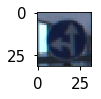

In [18]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[5000].squeeze(), cmap="gray")
print(y_train[5000])

**Display image after preprocessing**

37


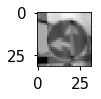

In [19]:
plt.figure(figsize=(1,1))
plt.imshow(preprocessed_X_train[5000].squeeze(), cmap="gray")
print(y_train[5000])

The preprocessing steps are based on the ones found in III.2 of [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf):
1. Convert to YUV scale

 * The Y component determines the brightness of the color. Looking only at the Y component can be equivalent to looking at a gray-scale of the image. 
 * Sermanent and LeCun described that preprocessing on just the Y channel resulted in higher accuracies. In other words, color appears to not have a significant effect in distinguising signs.  
<br>
2. Normalization

 * Ensure the data has a zero mean and equal variance    
<br>
3. Contrast Limited Adaptive Histogram Equlization (CLAHE)
   * CLAHE is created with the OpenCV function `cv2.createCLAHE()` in order to adjust the intensity range and enhance the image contrast. CLAHE is similar to histogram equalization except that local contrast is emphasized rather than globally. The image is divided into tiles and each tile is equalized according to its histogram. The 'Limited' comes into play when pixels are clipped according to a specified contrast limit. See [OpenCV Histogram Equalization](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) for more details.

### 2.2: Generate Fake Data

In [13]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range=90, zoom_range=0.1, 
                                    width_shift_range=0.25, height_shift_range=0.25)

Using TensorFlow backend.


In [14]:
data_generator.fit(preprocessed_X_train)

**Display generated data**

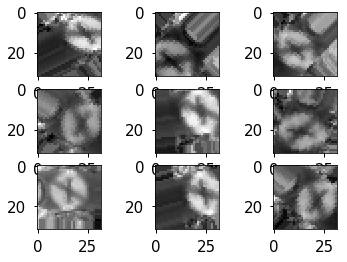

[41, 41, 41, 41, 41, 41, 41, 41, 41]


In [16]:
augmented_labels = list()
test_img = preprocessed_X_train[0:9]
# configure batch size and retrieve one batch of images
for X_batch, y_batch in data_generator.flow(test_img, y_train[0:9], batch_size=9):
    # create a grid of 3x3 images
    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].squeeze(), cmap="gray")
        augmented_labels.append(y_batch[i])
    plt.show()
    print(augmented_labels)
    break

In [17]:
# check counts of each sign
y_train_dict

Counter({0: 180,
         1: 1980,
         2: 2010,
         3: 1260,
         4: 1770,
         5: 1650,
         6: 360,
         7: 1290,
         8: 1260,
         9: 1320,
         10: 1800,
         11: 1170,
         12: 1890,
         13: 1920,
         14: 690,
         15: 540,
         16: 360,
         17: 990,
         18: 1080,
         19: 180,
         20: 300,
         21: 270,
         22: 330,
         23: 450,
         24: 240,
         25: 1350,
         26: 540,
         27: 210,
         28: 480,
         29: 240,
         30: 390,
         31: 690,
         32: 210,
         33: 599,
         34: 360,
         35: 1080,
         36: 330,
         37: 180,
         38: 1860,
         39: 270,
         40: 300,
         41: 210,
         42: 210})

In [18]:
# generate data so that each class has 1000 images
augmented_data = list()
augmented_labels = list()

for label in range(n_classes):
    label_indices = np.where(y_train == label)
    num_samples = len(label_indices[0])
    print('%d: %d' % (label, num_samples))
    if num_samples < 1000:
        num_to_generate = 1000 - num_samples
        sample_imgs = preprocessed_X_train[np.random.choice(label_indices[0].tolist(), num_to_generate)]
        counter = 0
        for x, y in data_generator.flow(preprocessed_X_train[label_indices], y_train[label_indices], \
                                        batch_size=1):
            augmented_data.append(x.reshape((32,32,1)))
            augmented_labels.append(y[0])
            counter += 1
            if counter == num_to_generate:
                break
        print('Generated => %d: %d' % (label, num_to_generate))
            
print('X_augmented, y_augmented:', len(augmented_data), len(augmented_labels))

0: 180
Generated => 0: 820
1: 1980
2: 2010
3: 1260
4: 1770
5: 1650
6: 360
Generated => 6: 640
7: 1290
8: 1260
9: 1320
10: 1800
11: 1170
12: 1890
13: 1920
14: 690
Generated => 14: 310
15: 540
Generated => 15: 460
16: 360
Generated => 16: 640
17: 990
Generated => 17: 10
18: 1080
19: 180
Generated => 19: 820
20: 300
Generated => 20: 700
21: 270
Generated => 21: 730
22: 330
Generated => 22: 670
23: 450
Generated => 23: 550
24: 240
Generated => 24: 760
25: 1350
26: 540
Generated => 26: 460
27: 210
Generated => 27: 790
28: 480
Generated => 28: 520
29: 240
Generated => 29: 760
30: 390
Generated => 30: 610
31: 690
Generated => 31: 310
32: 210
Generated => 32: 790
33: 599
Generated => 33: 401
34: 360
Generated => 34: 640
35: 1080
36: 330
Generated => 36: 670
37: 180
Generated => 37: 820
38: 1860
39: 270
Generated => 39: 730
40: 300
Generated => 40: 700
41: 210
Generated => 41: 790
42: 210
Generated => 42: 790
X_augmented, y_augmented: 16891 16891


In [20]:
# add generated data
X_train = np.append(preprocessed_X_train, augmented_data, axis=0)
y_train = np.append(y_train, augmented_labels, axis=0)

print('X_train: %d, y_train: %d' % (len(X_train), len(y_train)))

X_train: 51690, y_train: 51690


### 2.3: Model Architecture

In [22]:
def conv2d(x, W, b, strides=1, padding='SAME'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [23]:
def maxpool2d(x, k=2, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)

In [24]:
def create_weights(shape, w_mean, w_stddev):
    return tf.Variable(tf.truncated_normal(shape, stddev=w_stddev, mean=w_mean))

def create_bias(shape):
    return tf.Variable(tf.zeros(shape))

In [25]:
def conv_net(x, mu=0, sigma=0.01):
    # Layer 1: Convolutional with Input = 32x32x3 and Output = 28x28x6
    F_W_1 = tf.Variable(tf.truncated_normal((5,5,1,256), mean = mu, stddev = sigma)) #(height, width, input_depth, output_depth)
    F_b_1 = tf.Variable(tf.zeros(256)) #(output_depth)
    
    conv_1 = conv2d(x, F_W_1, F_b_1)
    
    # Pooling layer with Input = 28x28x6 and Output = 14x14x6
    pool_1 = maxpool2d(conv_1)
    
#     pool_1 = tf.nn.dropout(pool_1, keep_prob)

    # Layer 2: Convolutional with Output = 10x10x16
    F_W_2 = tf.Variable(tf.truncated_normal((5,5,256,512), mean = mu, stddev = sigma))
    F_b_2 = tf.Variable(tf.zeros(512))
    
    conv_2 = conv2d(pool_1, F_W_2, F_b_2)
    
    # Pooling with Input = 10x10x16 and Output = 5x5x16
    pool_2 = maxpool2d(conv_2)
    
#     pool_2 = tf.nn.dropout(pool_2, keep_prob)
    
    # Layer 3: Convolutional with Output = 5x5x400
    F_W_3 = tf.Variable(tf.truncated_normal((5,5,512,1024), mean = mu, stddev = sigma))
    F_b_3 = tf.Variable(tf.zeros(1024))
    
    conv_3 = conv2d(pool_2, F_W_3, F_b_3)
    
#     conv_3 = tf.nn.dropout(conv_3, keep_prob)
    
    # Pooling with Input = 10x10x16 and Output = 5x5x16
    pool_3 = maxpool2d(conv_3)
    
#     pool_3 = tf.nn.dropout(pool_3, keep_prob)
    
    # Flatten Input = 5x5x16
    flat_layer = tf.concat([flatten(pool_1), flatten(conv_3)], 1)#flatten(pool_2), flatten(conv_3)])

#     flat_layer = tf.nn.dropout(flat_layer, keep_prob)
    
    # Layer 4: Fully Connected with Output = 120
    W_3 = tf.Variable(tf.truncated_normal((flat_layer._shape[1].value, 120), mean = mu, stddev = sigma))
    b_3 = tf.Variable(tf.zeros(120))
    
    fc_1 = tf.add(tf.matmul(flat_layer, W_3), b_3)
    fc_1 = tf.nn.relu(fc_1)
    fc_1 = tf.nn.dropout(fc_1, keep_prob)
    
    # Layer 5: Fully Connected with Input = 120 and Output = 84
    W_4 = tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma))
    b_4 = tf.Variable(tf.zeros(84))
    
    fc_2 = tf.add(tf.matmul(fc_1, W_4), b_4)
    fc_2 = tf.nn.relu(fc_2)
    fc_2 = tf.nn.dropout(fc_2, keep_prob)
    
    # Layer 6: Fully Connected with Input = 84 and Output = 43
    W_5 = tf.Variable(tf.truncated_normal((84, 43), mean = mu, stddev = sigma))
    b_5 = tf.Variable(tf.zeros(43))
    
    logits = tf.add(tf.matmul(fc_2, W_5), b_5)
    
    regularizers = (tf.nn.l2_loss(F_W_1) + tf.nn.l2_loss(F_W_2) + tf.nn.l2_loss(F_W_3) + tf.nn.l2_loss(W_3) \
                    + tf.nn.l2_loss(W_4) + tf.nn.l2_loss(W_5))
    
    return (logits, regularizers)

In [44]:
def LeNet(x, mu=0, sigma=0.01):    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    F_W_1 = tf.Variable(tf.truncated_normal((5, 5, 1, 128), mean = mu, stddev = sigma)) # (heights, width, input_depth, output_depth)
    F_b_1 = tf.Variable(tf.zeros(128)) # (output_depth)
    
    conv_1 = conv2d(x, F_W_1, F_b_1)
    
    pool_1 = maxpool2d(conv_1)
    
    pool_1 = tf.nn.dropout(pool_1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    F_W_2 = tf.Variable(tf.truncated_normal((5, 5, 128, 256), mean = mu, stddev = sigma)) # (heights, width, input_depth, output_depth)
    F_b_2 = tf.Variable(tf.zeros(256)) # (output_depth)
    
    conv_2 = conv2d(conv_1, F_W_2, F_b_2)
    
    pool_2 = maxpool2d(conv_2)

    pool_2 = tf.nn.dropout(pool_2, keep_prob)
    # Flatten with Input = 5x5x16 and Output = 400.
    flat_layer = flatten(pool_2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W_3 = tf.Variable(tf.truncated_normal((flat_layer._shape[1].value, 120), mean = mu, stddev = sigma))
    b_3 = tf.Variable(tf.zeros(120))

    layer_3 = tf.matmul(flat_layer, W_3) + b_3

    fc_1 = tf.nn.relu(layer_3)
    
    fc_1 = tf.nn.dropout(fc_1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W_4 = tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma))
    b_4 = tf.Variable(tf.zeros(84))
    
    layer_4 = tf.matmul(fc_1, W_4) + b_4

    fc_2 = tf.nn.relu(layer_4)
    
    fc_2 = tf.nn.dropout(fc_2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    W_5 = tf.Variable(tf.truncated_normal((84, 43), mean = mu, stddev = sigma))
    b_5 = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc_2, W_5) + b_5

    return logits

### 2.4: Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Set placeholders for features and labels
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [26]:
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

In [21]:
# how many times to run training data through network
EPOCHS = 30
# how many images to run through the network at a time 
BATCH_SIZE = 512

In [27]:
# learning rate to tell TF how quickly to update weights
rate = 0.001

# logits, regularizers = conv_net(x)
logits, regularizers = conv_net(x)
# compare logits to one hot encoded ground truth
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
# avg cross entropy across all training images
loss_operation_no_reg = tf.reduce_mean(cross_entropy)
# use Adam alg to minimize loss function similar to SGD
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# add L2 reg
loss_operation = tf.reduce_mean(loss_operation_no_reg + 1e-5 * regularizers)
# use backpropogation to update network and min loss
training_operation = optimizer.minimize(loss_operation_no_reg)

### Evaluation Pipeline
Evaluate the loss and accuracy of the model for the given dataset.

In [28]:
# measure whether prediction is correct by comparing logit prediction to one hot encoded ground truth
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# calc overall model accuracy by avg individual predictions
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    """Evaluation pipeline
    
    Parameters
    ----------
    X_data : numpy.ndarray
        Array representing image
        
    y_data : numpy.ndarray
        Array representing labels
    
    Returns
    -------
    acc : float
        Overall model accuracy
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and Validate Model
Run the training data through the training pipeline to train the model.

Before each epoch, the training set is shuffled.

After each epoch, the loss and accuracy of the validation set is measured.

The model is saved after training.

In [29]:
validation_acc_dict = dict()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        t0 = time.time()
        # shuffle data to ensure training isn't biased by order
        new_X_train, new_y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            # break data into batches
            end = offset + BATCH_SIZE
            batch_x, batch_y = new_X_train[offset:end], new_y_train[offset:end]
            # train on each batch
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.50})
        # evaluate model on training
        training_accuracy = evaluate(X_train, y_train)
        # evaluate model on validation 
        validation_accuracy = evaluate(preprocessed_X_valid, y_valid)
        t1 = time.time()
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Total time: %f sec" % (t1-t0))
        print()
        validation_acc_dict[i] = validation_accuracy
    # save model once training is completed
    saver.save(sess, './conv_net')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.422
Validation Accuracy = 0.541
Total time: 49.180313 sec

EPOCH 2 ...
Training Accuracy = 0.625
Validation Accuracy = 0.741
Total time: 41.893344 sec

EPOCH 3 ...
Training Accuracy = 0.708
Validation Accuracy = 0.832
Total time: 42.023731 sec

EPOCH 4 ...
Training Accuracy = 0.765
Validation Accuracy = 0.862
Total time: 42.595385 sec

EPOCH 5 ...
Training Accuracy = 0.788
Validation Accuracy = 0.895
Total time: 42.770877 sec

EPOCH 6 ...
Training Accuracy = 0.830
Validation Accuracy = 0.907
Total time: 42.868474 sec

EPOCH 7 ...
Training Accuracy = 0.865
Validation Accuracy = 0.913
Total time: 42.961702 sec

EPOCH 8 ...
Training Accuracy = 0.884
Validation Accuracy = 0.929
Total time: 43.198567 sec

EPOCH 9 ...
Training Accuracy = 0.905
Validation Accuracy = 0.932
Total time: 43.086825 sec

EPOCH 10 ...
Training Accuracy = 0.925
Validation Accuracy = 0.935
Total time: 43.227966 sec

EPOCH 11 ...
Training Accuracy = 0.940
Validation Accura

### Evaluate Model
Evaluate the performance of the model on the test set after deciding 'best' model.

In [31]:
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('conv_net.meta')
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(preprocessed_X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./conv_net
Test Accuracy = 0.943


### Final model architecture

| Layer        | Depth           | Kernel Size | Stride Size  | Activation | Pooling
| :------------- |:-------------| :-----| :-- | :-- | :-- | :-- |
| Input (32x32x3) 
| Convolutional | 256 | 5x5| 1x1| ReLU| (2,2), `same`
| Convolutional | 512| 5x5| 1x1| ReLU| (2,2), `same`
| Convolutional | 1024| 5x5| 1x1| ReLU| (2,2), `same`
| Flatten|       
| Fully Connected | 120| |  |ReLU|
| Fully Connected | 84 | |  |ReLU| 
| Fully Connected | 43 | |  |

The approach to get a model with a validation accuracy of at least 0.93 was an iterative process as followed:
    
1. Start with LeNet architecture because it's a well known architecture that can be built upon as a starting foundation. The initial model did not have any regularization or drop out.
2. After iterating through different output depths with this initial LeNet architecture, I noticed that it was under/over performing. 
3. Due to time constraints I did not GridSearch the learn rates, batch sizes, or epochs but focused on developing a different architecture. 
4. The next model was based on the two stage CovNet described in the Sermanent and LeCun paper. With this model I would adjust the output depths between layers and compare model performance based on validation accuracy. 
5. The 'best' model was , where best is defined as the highest mean validation accuracy. 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [221]:
glob.glob('./test_images/*.jpg')

['./test_images/17_no_entry.jpg',
 './test_images/18_general_caution.jpg',
 './test_images/31_animal_crossing.jpg',
 './test_images/34_turn_left.jpg',
 './test_images/25_road_work.jpg',
 './test_images/8_speed_limit_120.jpg',
 './test_images/12_priority_road.jpg',
 './test_images/11_right_of_way.jpg']

In [232]:
sign_names = pd.read_csv('signnames.csv')
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


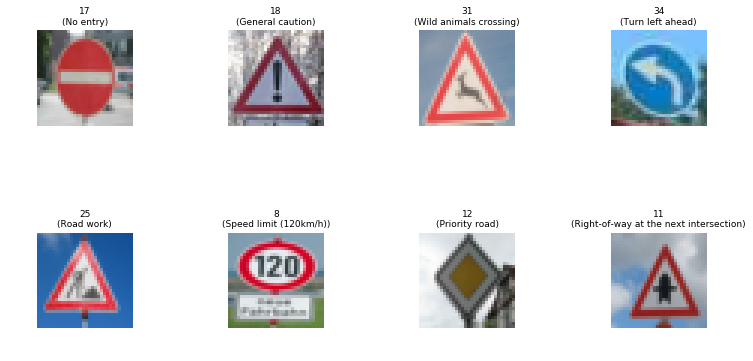

In [257]:
from scipy.misc import imresize
test_image_files = glob.glob('./test_images/*.jpg')
test_labels = [x.split('/')[2].split('_')[0] for x in test_image_files]
fig, axs = plt.subplots(2,4, figsize=(12, 12))
fig.subplots_adjust(hspace=-0.55, wspace=1)
axs = axs.ravel()

for i, img in enumerate(test_image_files):
    axs[i].axis('off')
    axs[i].set_title(test_labels[i] + '\n(' +\
                     sign_names.loc[sign_names.ClassId == int(test_labels[i]), 'SignName'].values[0] + ')',\
                     fontsize=9)
    axs[i].imshow(cv2.cvtColor(imresize(cv2.imread(img), (32, 32)), cv2.COLOR_BGR2RGB))

### Predict the Sign Type for Each New Image

INFO:tensorflow:Restoring parameters from ./conv_net

Accuracy: 0.88


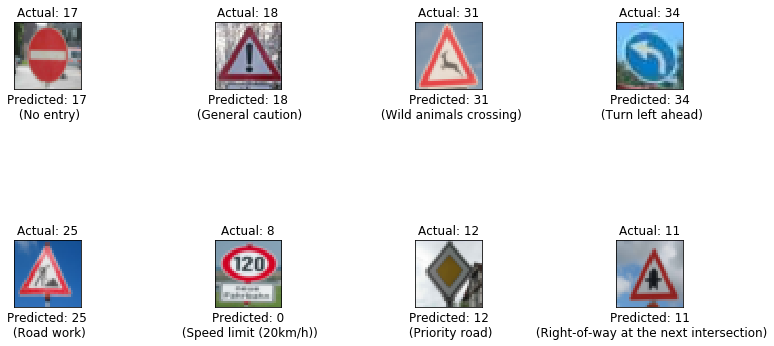

In [277]:
test_images = np.array([imresize(cv2.imread(x), (32, 32)) for x in test_image_files])
preprocessed_test_images = preprocess(test_images)

with tf.Session() as sess:
    # restore saved session
    saver = tf.train.import_meta_graph('conv_net.meta')
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    
    # predict on new images
    predictions = np.argmax(np.array(sess.run(logits, feed_dict={x: preprocessed_test_images, keep_prob: 1.})), axis=1)

fig, axs = plt.subplots(2,4, figsize=(12, 12))
fig.subplots_adjust(hspace=-0.5, wspace=2)
axs = axs.ravel()

for i, pred in enumerate(predictions):
    axs[i].set_title('Actual: %s' % (test_labels[i]), fontsize=12)
    axs[i].imshow(cv2.cvtColor(imresize(cv2.imread(test_image_files[i]), (32, 32)), cv2.COLOR_BGR2RGB))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel('Predicted: %s\n (%s)' % (pred, sign_names.loc[sign_names.ClassId == pred, 'SignName'].values[0]), 
                      fontsize=12)
    
print('\nAccuracy: {:.02f}'.format(np.sum([int(x) for x in test_labels]==predictions)/len(test_labels)))

The model performs somewhat well (87.5% accuracy) on the images from the web. We can see that the image it incorrectly classified is the "Speed limit (120km/h)", which it thought was the "Speed limit (20km/h)" sign. Although this performance is lower than the test set accuracy, this could be due to the small sample size.

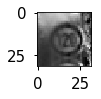

In [485]:
# Plot training exampe of "Speed limit(120 km/h)"
plt.figure(figsize=(1,1))
plt.imshow(preprocessed_X_train[15875].squeeze(), cmap="gray")

We can see that the training example doesn't have the secondary sign below it compared to the new test image which could be the reason it was misclassified. I could try to include more training images of this type with multiple signs. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./conv_net


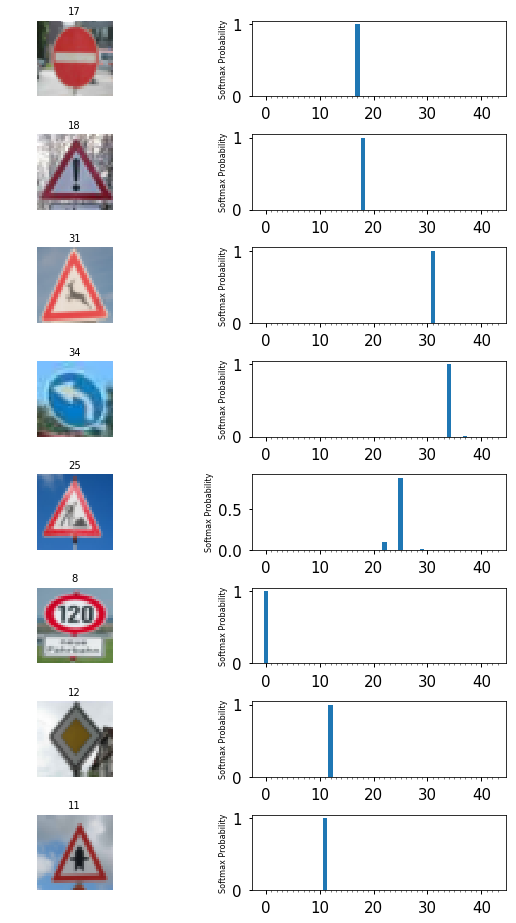

In [230]:
with tf.Session() as sess:
    # restore saved session
    saver = tf.train.import_meta_graph('conv_net.meta')
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    
    # get values and indicies of top 5 predictions (model certainty)
    top_5 = sess.run(tf.nn.top_k(logits, k=5), feed_dict={x: preprocessed_test_images, keep_prob: 1.})

    # get softmax probabilities 
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: preprocessed_test_images, keep_prob: 1.})
    
    fig, axs = plt.subplots(8,2, figsize=(10, 16))
    fig.subplots_adjust(hspace=0.5)
    axs = axs.ravel()
    
    for i in range(16):
        if i % 2 == 0:
            axs[i].axis('off')
            axs[i].set_title('%s' % (test_labels[i//2]), fontsize=10)
            axs[i].imshow(cv2.cvtColor(imresize(cv2.imread(test_image_files[i//2]), (32, 32)), cv2.COLOR_BGR2RGB))
        else:
            axs[i].bar(np.arange(n_classes), softmax_probs[i//2])
            axs[i].set_xticks(np.arange(0, 44), 1)
            axs[i].set_ylabel('Softmax Probability', fontsize=8)

Based on the softmax probability plots we can see that the model has a high level of certainty for almost all the images. 